 # Frozen Lake, Not Slippery
    
    In this notebook, I implement 3 RL algorithms: Q-Learning, SARSA, and Cross-Entropy. For each algorithm, I produce multiple plots of average rewards vs num of episodes comparing various paraters.

# Setup


In [118]:
import numpy
import collections
import gym
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim


## Some Function Definitions

In [119]:
def get_action( state, q_values, epsilon):
    """
    Select an action from [0,1,2,3] (representing ["Left", "Down", "Right", "Up"] using epsilon-greedy.
    :param state: the state of interest
    :param q_values: a map of q_values.
    :param epsilon: probability of using a uniform distribution to select an action
    
    :return: an action
    """
    # Extract the action values.
    action_values = [q_values[(state, 0)], q_values[(state, 1)],q_values[(state, 2)], q_values[(state, 3)]]

    # Then initialize their probabilities as uniform over epsilon.
    action_probs = [epsilon/4, epsilon/4, epsilon/4, epsilon/4]

    # Find the max action value's index, then add (1-epsilon) to its probability.
    maxqsa = max(action_values)

    # if the maximum is 0.0, then all values are still 0.0, therefore force a uniform distribution..
    if maxqsa == 0.0:
        action_probs = [0.25, 0.25, 0.25, 0.25]
    else:
        action = action_values.index(maxqsa)
        action_probs[action] = action_probs[action] + 1-epsilon

    # sample over the probabilities
    return numpy.random.choice([0, 1, 2, 3], p=action_probs )


In [120]:
def get_max_Q(state, q_values):
    """ Given a state, return the max Qvalue among all the actions
    :param state: the state of interest
    :param q_values: a dict with keys as (s,a) and values as q_values.
    :return: max Qvalue among all the actions
    """
    state_action_values = [q_values[(state, 0)], q_values[(state, 1)], q_values[(state, 2)], q_values[(state, 3)]]
    maxQsa = max(state_action_values)
    return maxQsa

In [121]:
def update_ave_rewards(ave_rewards, episode, rewards):
    """
    This function is used to update average rewards per episode.
    The ave_rewards is an array contains a list of successive ave rewards vs num_episodes.
    parameter episode is the index of the ith episode. Therefore its entry will be the average of the (episode-1)th average
    muliplied by (episode-1) then adding rewards, then dividing by episode. Need to figure out zero-indexing.

    :param ave_rewards: a list as described above. The value of  the index is the num of (episodes+1), and the value contains
        the average of rewards across those episodes
    :param episode: the episode index: int
    :param rewards: the scalar reward
    :return: None
    """
    assert episode == len(ave_rewards), "Episode:{} should equal len(ave_rewards):{}".format(episode, len(ave_rewards))
    if episode == 0:
        ave_rewards.append(rewards)
    else:
        reward_sum = ave_rewards[episode-1] * (episode-1)
        reward_sum += rewards
        reward_ave = reward_sum / episode
        ave_rewards.append(reward_ave)


### Q-Learning main algorithm

In [122]:
def q_learn(env, num_episodes, gamma, alpha, epsilon):
    """
    This implements the Q-Learning algorithm.
    :param env_name: The environment
    :param num_episodes: Num of episodes to iterate over.
    :param gamma: the discount parameter for computing rewards
    :param alpha: the learning rate
    :param epsilon: Epsilon parameter for epsilon-greedy action selection.
    :return: an array of average_rewards
    """

    Q_values = collections.defaultdict(float)  # dict of (state,action):value
    actions = {}  # dict of episode:[actions]
    rewards = {}  # dict of episode: total rewards for tha episode
    ave_rewards = []  # array of  ave rewards across all episodes until episode index
    nonzero_states = []  # array of non-zero states. index is episode.

    for i_episode in range(num_episodes):
        state = env.reset()  # Initialize S
        actions[i_episode] = []
        rewards[i_episode] = 0.0
        done = False
        while not done:  # Loop until end of episode
            action = get_action(state, Q_values, epsilon)  # Choose A from S using policy (e.g. epsilon-greedy)
            actions[i_episode].append(action)
            newstate, reward, done, info = env.step(action)  # Take action A, observe R, S'
            Q_values[(state, action)] = Q_values[(state, action)] + alpha * (
                    reward + gamma * get_max_Q(newstate, Q_values) - Q_values[(state, action)])
            state = newstate
            rewards[i_episode] += reward

        
        update_ave_rewards(ave_rewards, i_episode, rewards[i_episode])
    
    print("Completed Q-Learning run with gamma={}, learning rate={}".format(gamma, alpha))
    return ave_rewards


### SARSA main algorithm

In [123]:
def sarsa(env, num_episodes, gamma, alpha, epsilon):
    """
    This implements the SARSA algorithm.
    :param env_name: the environment
    :param num_episodes: The number of episodes to iterate over.
    :param gamma: The discount parameter for computing rewards
    :param alpha: the learning rate
    :param epsilon: Epsilon parameter for epsilon-greedy action selection.
    
    :return: array of average rewards
    """

    actions = {}  # dict of episode:[actions]
    rewards = {}  # dict of episode: total rewards for tha episode
    ave_rewards = []  # array of  ave rewards across all episodes until episode index


    q_values = collections.defaultdict(float)  # dict of (state,action):value
    for i_episode in range(num_episodes):

        state = env.reset()  # Initialize S
        action = get_action(state, q_values, epsilon)  # Choose A from S using policy (e.g. epsilon-greedy)
        actions[i_episode] = []
        actions[i_episode].append(action)
        rewards[i_episode] = 0.0
        done = False
        while not done:  # Repeat for each step of the episode
            newstate, reward, done, info = env.step(action)  # Take action A, observe R, S'
            newaction = get_action(newstate, q_values, epsilon)  # Choose A' from S' using policy (e.g. epsilon-greedy)
            q_values[(state, action)] = q_values[(state, action)] + alpha * (
                    reward + gamma * q_values[(newstate, newaction)] - q_values[(state, action)])
            state = newstate
            action = newaction
            rewards[i_episode] += reward

        update_ave_rewards(ave_rewards, i_episode, rewards[i_episode])
        
        
    print("Completed SARSA Learning run with gamma={}, learning rate={}".format(gamma, alpha))
    return ave_rewards


## Q-Learning runs

Completed Q-Learning run with gamma=0.1, learning rate=0.1
Completed Q-Learning run with gamma=0.1, learning rate=0.5
Completed Q-Learning run with gamma=0.1, learning rate=0.9
Completed Q-Learning run with gamma=0.5, learning rate=0.1
Completed Q-Learning run with gamma=0.5, learning rate=0.5
Completed Q-Learning run with gamma=0.5, learning rate=0.9
Completed Q-Learning run with gamma=0.9, learning rate=0.1
Completed Q-Learning run with gamma=0.9, learning rate=0.5
Completed Q-Learning run with gamma=0.9, learning rate=0.9


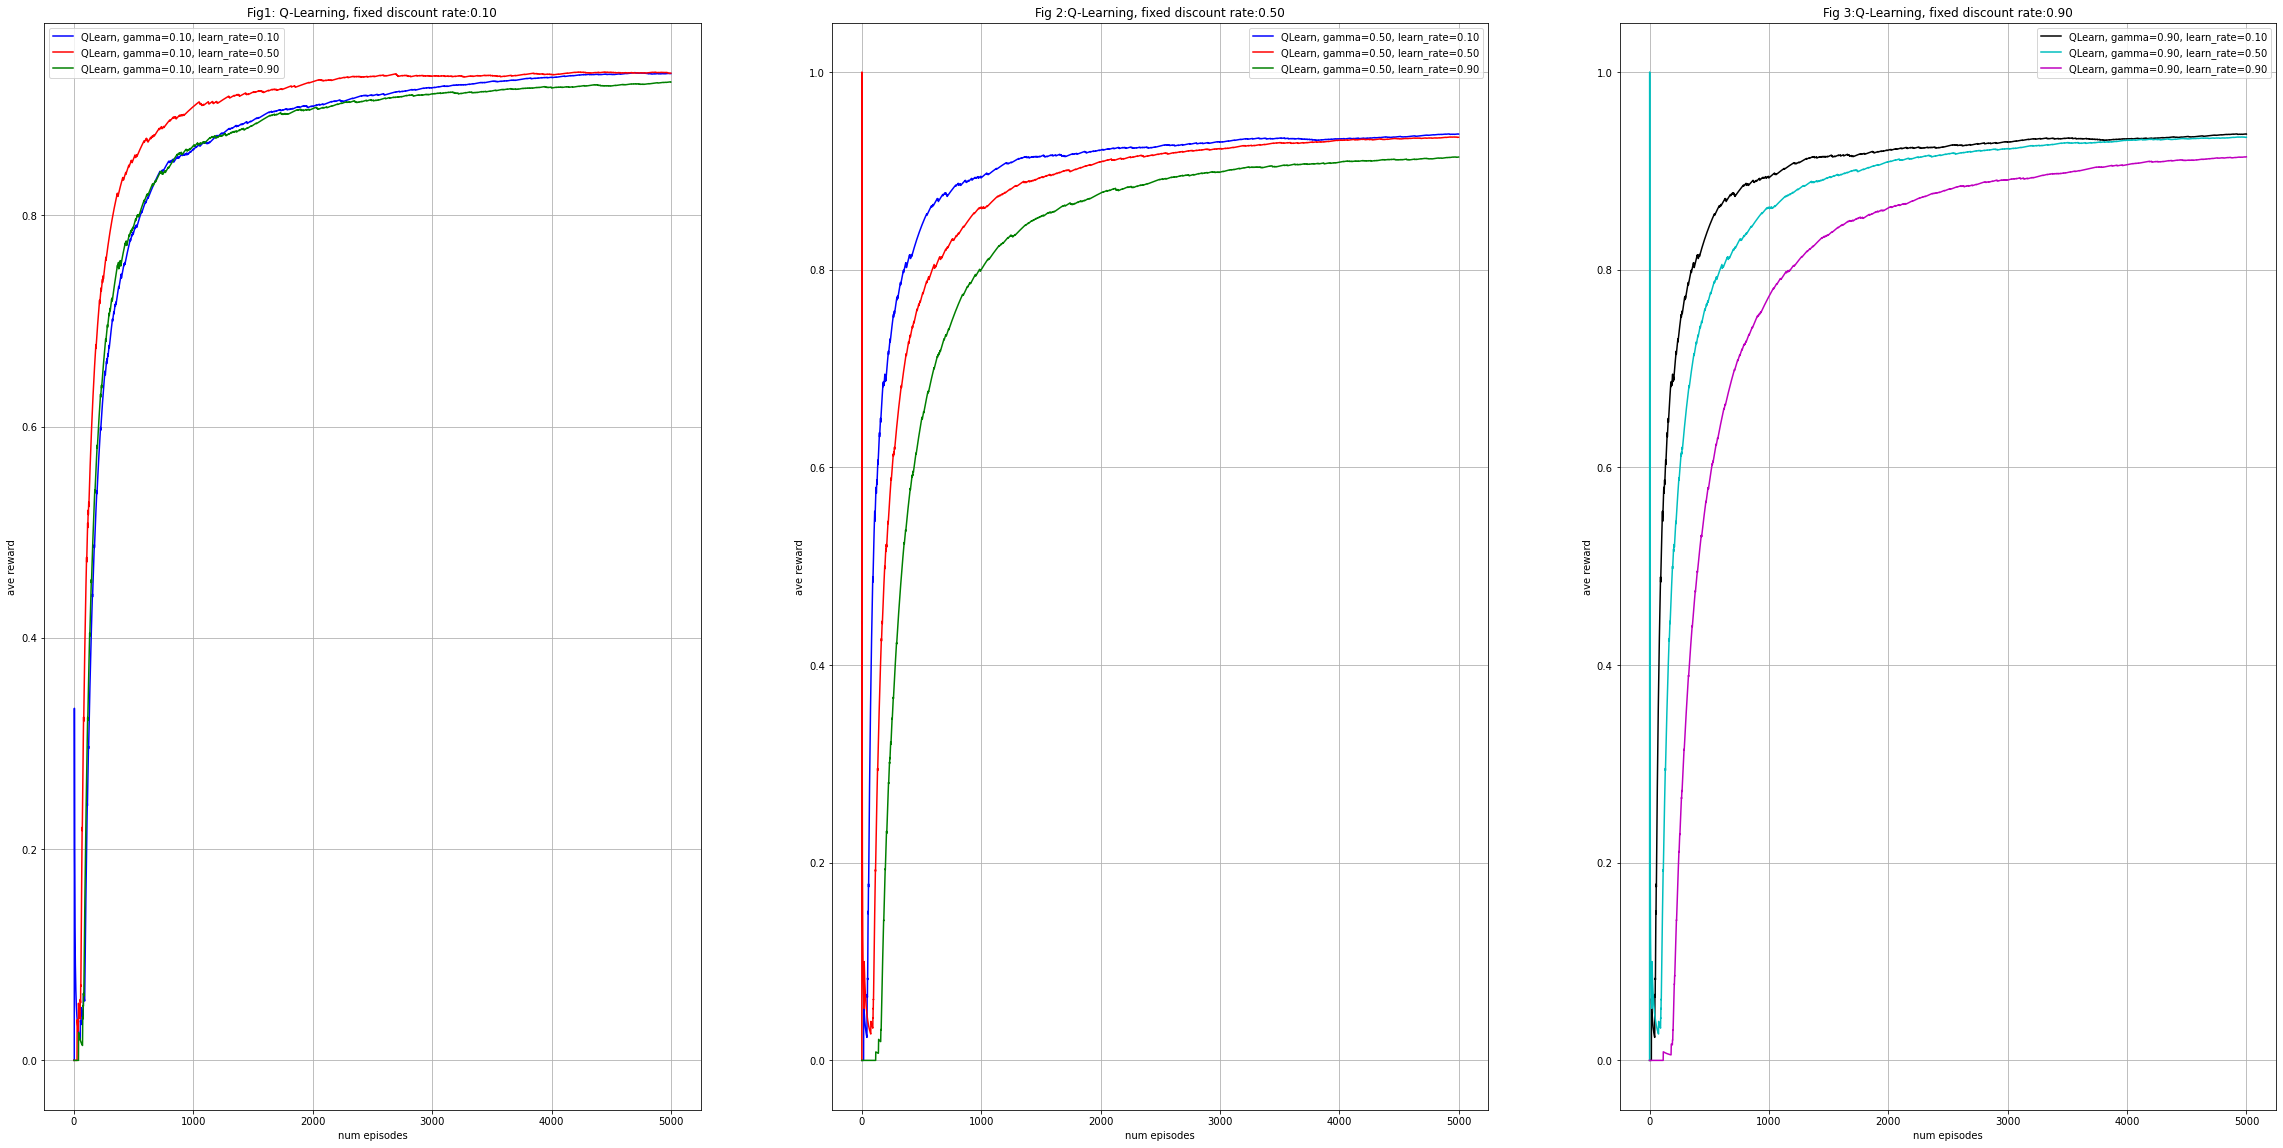

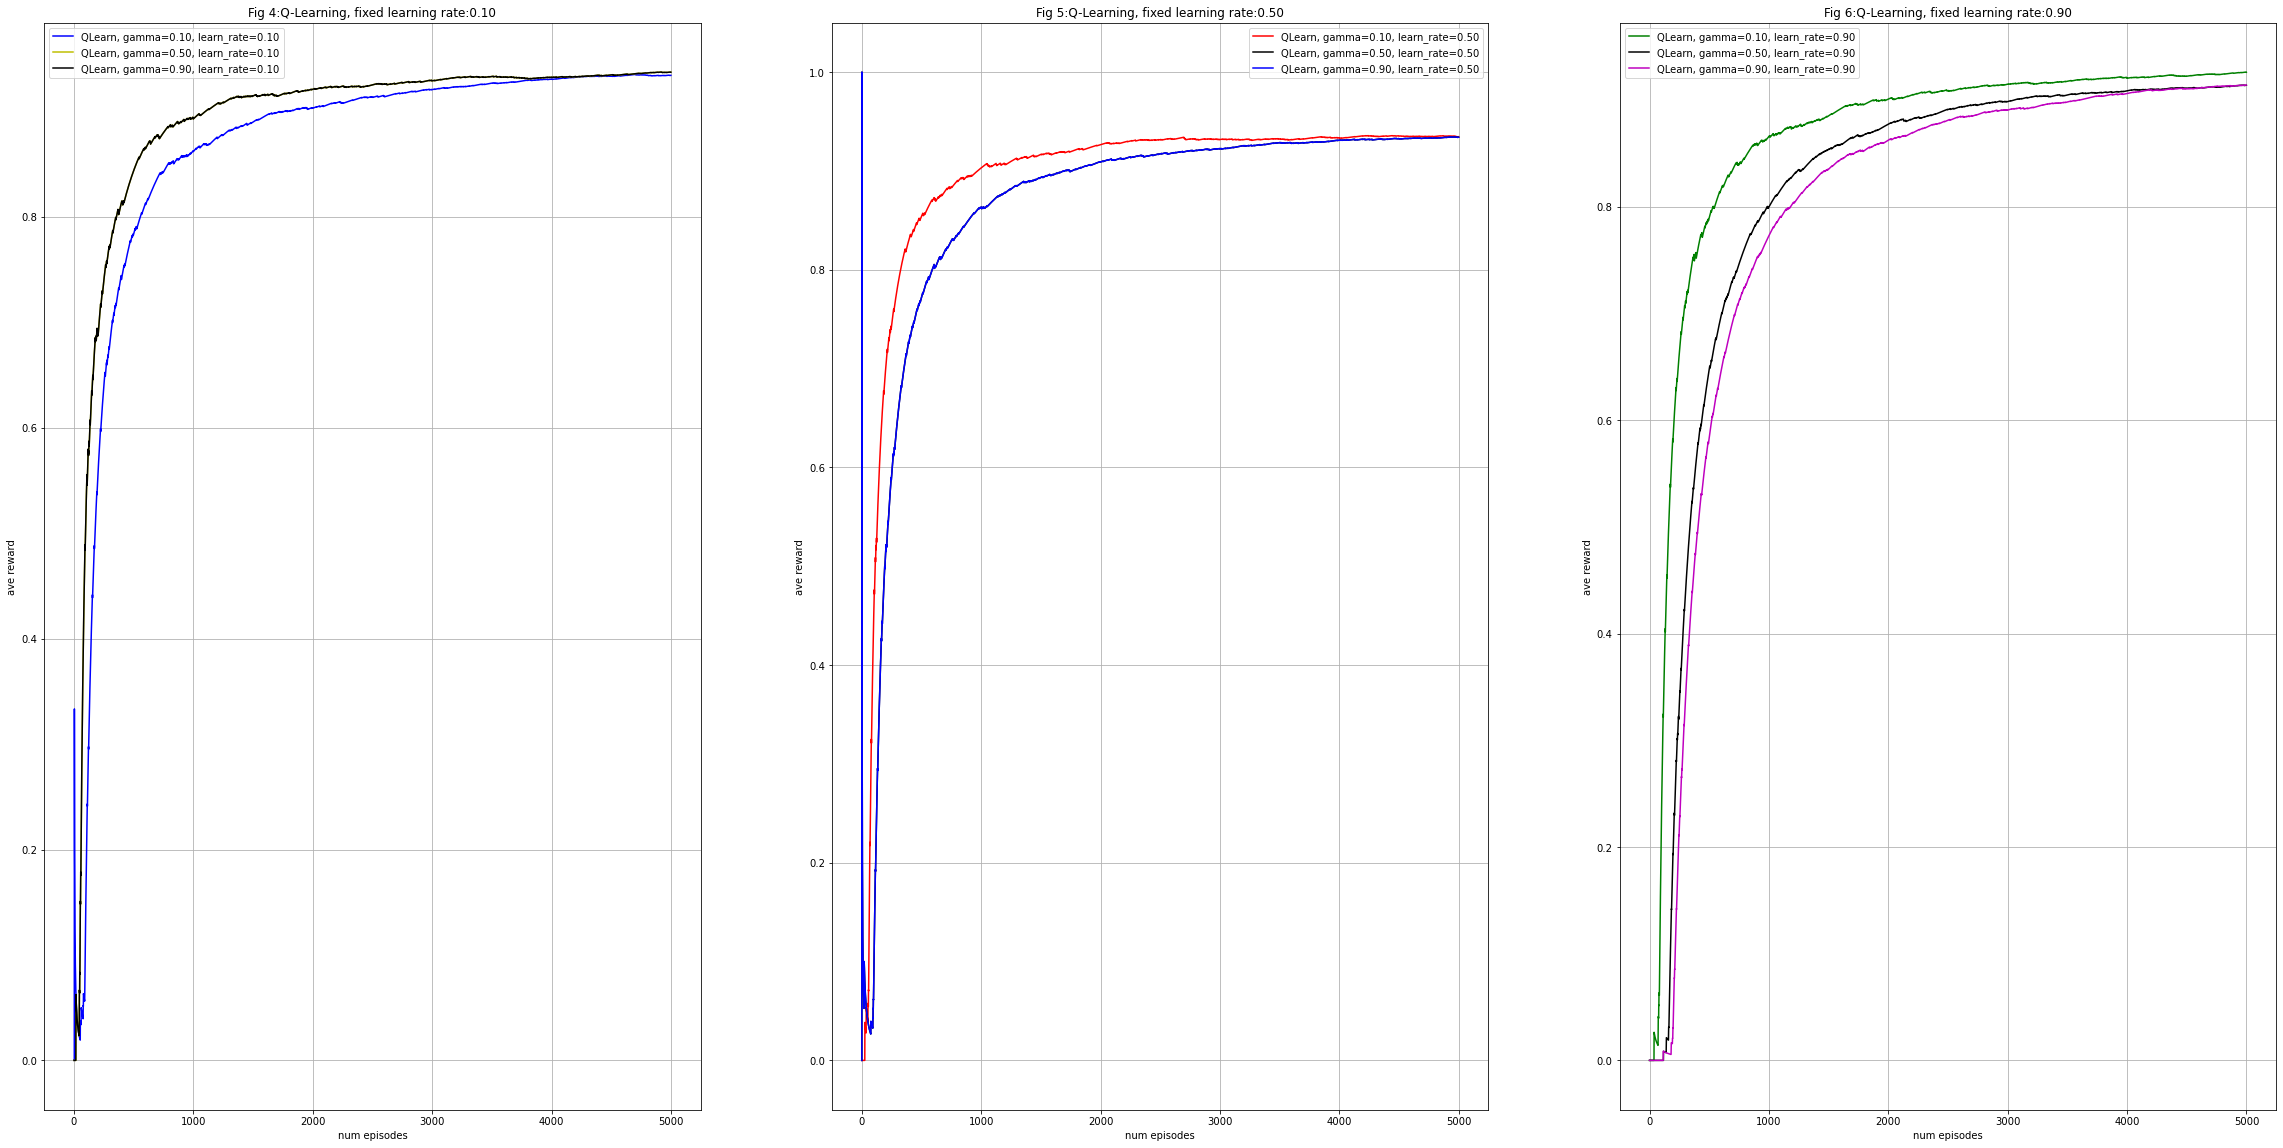

In [124]:

num_episodes = 5000
epsilon = 0.05
#plt.rcParams['figure.figsize'] = [20, 20]
fig1, ((ax1, ax2, ax3)) = plt.subplots(1, 3)
fig2, ((ax4, ax5, ax6)) = plt.subplots(1, 3)    

env = gym.make('FrozenLake-v0', is_slippery=False)
    
gamma = 0.1
alpha = 0.1
q_ave_rewards_1 = q_learn(env, num_episodes, gamma, alpha, epsilon)
ax1.plot(q_ave_rewards_1, 'b', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax4.plot(q_ave_rewards_1, 'b', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.1
alpha = 0.5    
q_ave_rewards_2 = q_learn(env, num_episodes, gamma, alpha, epsilon)
ax1.plot(q_ave_rewards_2, 'r', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax5.plot(q_ave_rewards_2, 'r', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.1
alpha = 0.9
q_ave_rewards_3 = q_learn(env, num_episodes, gamma, alpha, epsilon)
ax1.plot(q_ave_rewards_3, 'g', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax6.plot(q_ave_rewards_3, 'g', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha)) 
gamma = 0.5
alpha = 0.1
q_ave_rewards_4 = q_learn(env, num_episodes, gamma, alpha, epsilon)
ax2.plot(q_ave_rewards_4, 'b-', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax4.plot(q_ave_rewards_4, 'y', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.5
alpha = 0.5
q_ave_rewards_5 = q_learn(env, num_episodes, gamma, alpha, epsilon)
ax2.plot(q_ave_rewards_5, 'r-', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax5.plot(q_ave_rewards_5, 'k', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.5
alpha = 0.9
q_ave_rewards_6 = q_learn(env, num_episodes, gamma, alpha, epsilon)
ax2.plot(q_ave_rewards_6, 'g-', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax6.plot(q_ave_rewards_6, 'k', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))     
gamma = 0.9
alpha = 0.1
q_ave_rewards_7 = q_learn(env, num_episodes, gamma, alpha, epsilon)
ax3.plot(q_ave_rewards_4, 'k', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax4.plot(q_ave_rewards_4, 'k', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.9
alpha = 0.5
q_ave_rewards_8 = q_learn(env, num_episodes, gamma, alpha, epsilon)
ax3.plot(q_ave_rewards_5, 'c', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax5.plot(q_ave_rewards_5, 'b', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.9
alpha = 0.9
q_ave_rewards_9 = q_learn(env, num_episodes, gamma, alpha, epsilon)
ax3.plot(q_ave_rewards_9, 'm', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax6.plot(q_ave_rewards_9, 'm', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))        
ax1.legend()
ax1.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig1: Q-Learning, fixed discount rate:0.10')
ax1.grid()
    
ax2.legend()
ax2.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig 2:Q-Learning, fixed discount rate:0.50')
ax2.grid()

ax3.legend()
ax3.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig 3:Q-Learning, fixed discount rate:0.90')
ax3.grid()
    
ax4.legend()
ax4.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig 4:Q-Learning, fixed learning rate:0.10')
ax4.grid()
ax5.legend()
ax5.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig 5:Q-Learning, fixed learning rate:0.50')
ax5.grid()
ax6.legend()
ax6.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig 6:Q-Learning, fixed learning rate:0.90')
ax6.grid()


plt.show()
    


### Analysis
Looking at Figs 1-3, for a fixed discount rate (gamma), a high learning rate results in faster learning, except in Figure 3, where the best learning rate was 0.5 (middle value) 
In Figs 4-6, for a fixed learning rate, smaller discount rate seemed to produce the faster learning.

### SARSA experiments

Completed SARSA Learning run with gamma=0.1, learning rate=0.1
Completed SARSA Learning run with gamma=0.1, learning rate=0.5
Completed SARSA Learning run with gamma=0.1, learning rate=0.9
Completed SARSA Learning run with gamma=0.5, learning rate=0.1
Completed SARSA Learning run with gamma=0.5, learning rate=0.5
Completed SARSA Learning run with gamma=0.5, learning rate=0.9
Completed SARSA Learning run with gamma=0.9, learning rate=0.1
Completed SARSA Learning run with gamma=0.9, learning rate=0.5
Completed SARSA Learning run with gamma=0.9, learning rate=0.9


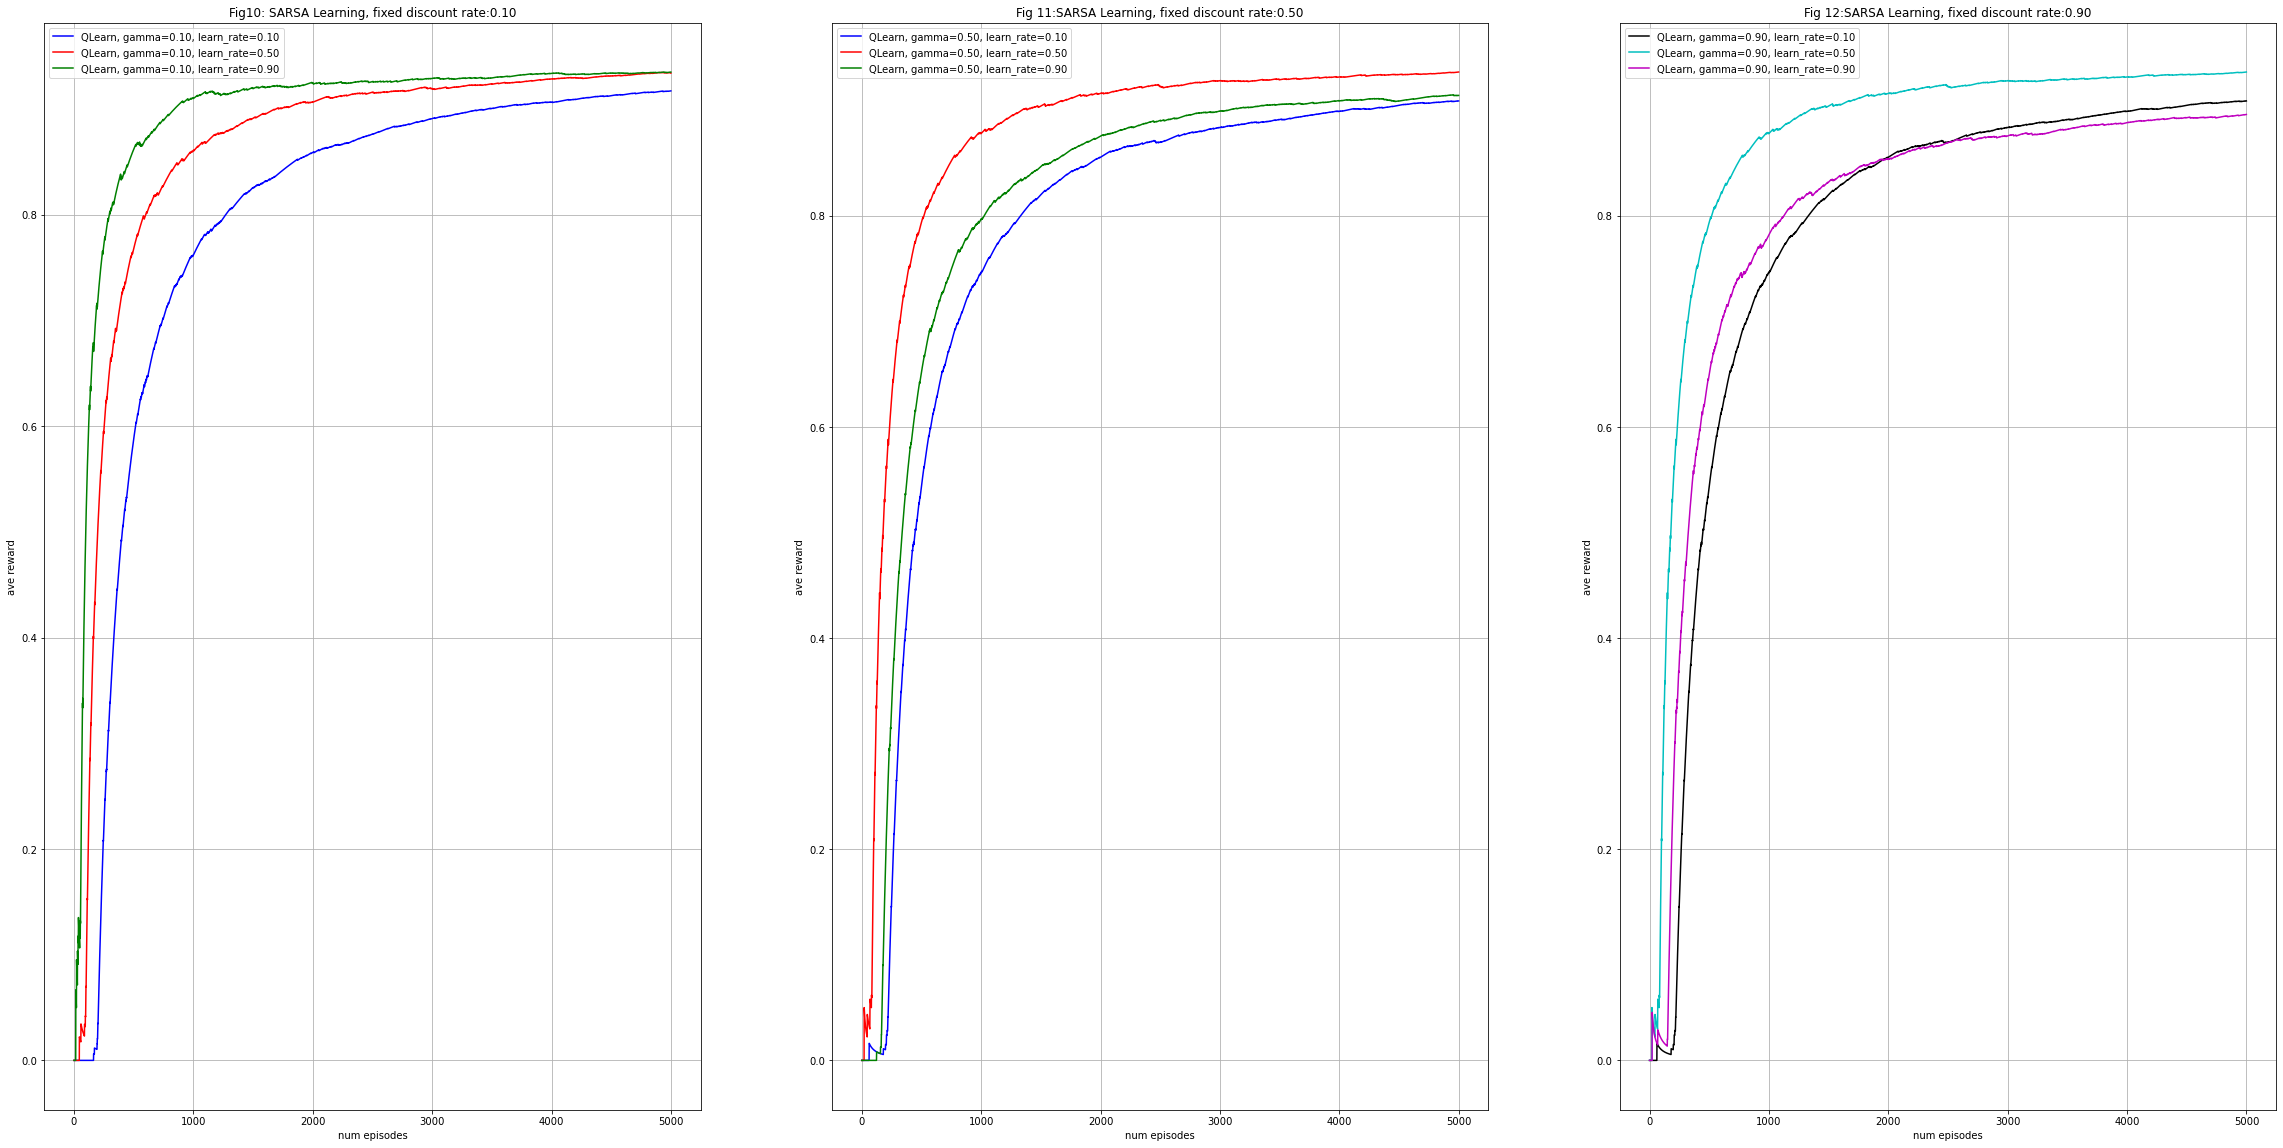

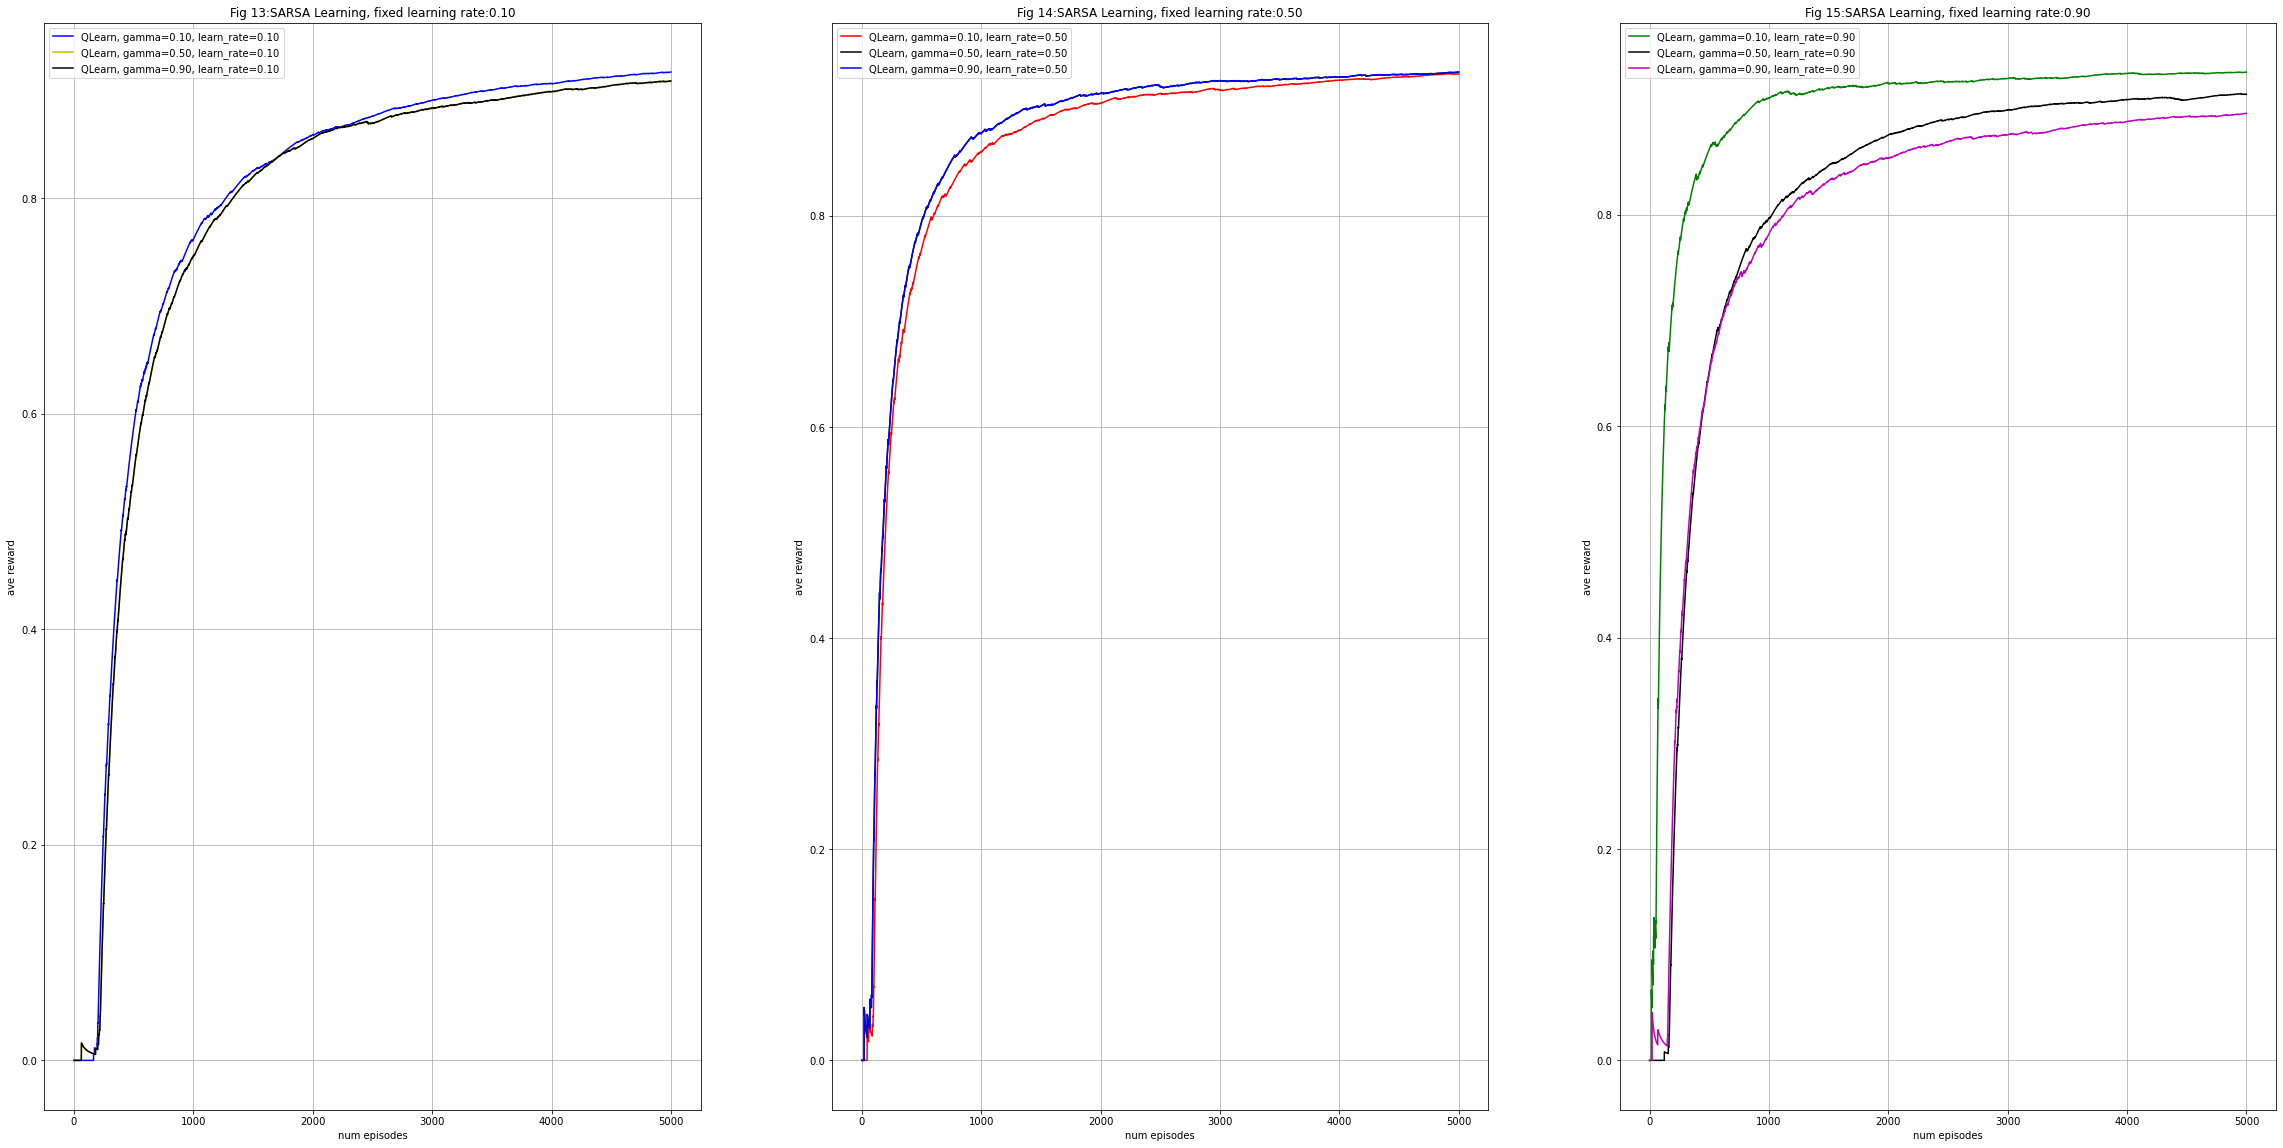

In [125]:
num_episodes = 5000
epsilon = 0.05
#plt.rcParams['figure.figsize'] = [20, 20]
fig1, ((ax1, ax2, ax3)) = plt.subplots(1, 3)
fig2, ((ax4, ax5, ax6)) = plt.subplots(1, 3)    

env = gym.make('FrozenLake-v0', is_slippery=False)
    
gamma = 0.1
alpha = 0.1
q_ave_rewards_1 = sarsa(env, num_episodes, gamma, alpha, epsilon)
ax1.plot(q_ave_rewards_1, 'b', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax4.plot(q_ave_rewards_1, 'b', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.1
alpha = 0.5    
q_ave_rewards_2 = sarsa(env, num_episodes, gamma, alpha, epsilon)
ax1.plot(q_ave_rewards_2, 'r', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax5.plot(q_ave_rewards_2, 'r', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.1
alpha = 0.9
q_ave_rewards_3 = sarsa(env, num_episodes, gamma, alpha, epsilon)
ax1.plot(q_ave_rewards_3, 'g', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax6.plot(q_ave_rewards_3, 'g', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha)) 
gamma = 0.5
alpha = 0.1
q_ave_rewards_4 = sarsa(env, num_episodes, gamma, alpha, epsilon)
ax2.plot(q_ave_rewards_4, 'b-', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax4.plot(q_ave_rewards_4, 'y', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.5
alpha = 0.5
q_ave_rewards_5 = sarsa(env, num_episodes, gamma, alpha, epsilon)
ax2.plot(q_ave_rewards_5, 'r-', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax5.plot(q_ave_rewards_5, 'k', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.5
alpha = 0.9
q_ave_rewards_6 = sarsa(env, num_episodes, gamma, alpha, epsilon)
ax2.plot(q_ave_rewards_6, 'g-', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax6.plot(q_ave_rewards_6, 'k', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))     
gamma = 0.9
alpha = 0.1
q_ave_rewards_7 = sarsa(env, num_episodes, gamma, alpha, epsilon)
ax3.plot(q_ave_rewards_4, 'k', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax4.plot(q_ave_rewards_4, 'k', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.9
alpha = 0.5
q_ave_rewards_8 = sarsa(env, num_episodes, gamma, alpha, epsilon)
ax3.plot(q_ave_rewards_5, 'c', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax5.plot(q_ave_rewards_5, 'b', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.9
alpha = 0.9
q_ave_rewards_9 = sarsa(env, num_episodes, gamma, alpha, epsilon)
ax3.plot(q_ave_rewards_9, 'm', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax6.plot(q_ave_rewards_9, 'm', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))        
ax1.legend()
ax1.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig10: SARSA Learning, fixed discount rate:0.10')
ax1.grid()
    
ax2.legend()
ax2.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig 11:SARSA Learning, fixed discount rate:0.50')
ax2.grid()

ax3.legend()
ax3.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig 12:SARSA Learning, fixed discount rate:0.90')
ax3.grid()
    
ax4.legend()
ax4.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig 13:SARSA Learning, fixed learning rate:0.10')
ax4.grid()
ax5.legend()
ax5.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig 14:SARSA Learning, fixed learning rate:0.50')
ax5.grid()
ax6.legend()
ax6.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig 15:SARSA Learning, fixed learning rate:0.90')
ax6.grid()


plt.show()
    

### Analysis
Looking at Figs 10-12, for a fixed discount rate (gamma), a high learning rate results in slowe learning. 
In Figs 13-15, for a fixed learning rate, smaller discount rate seemed to produce the faster learning.

### CROSS ENTROPY experiments

### Some support functions

In [126]:
class OneHotWrapper(gym.ObservationWrapper):
    """
    This is a wrapper class for the environment. So we could create wrapper functions around it.
    """
    def __init__(self, env):
        super(OneHotWrapper, self).__init__(env)
        self.observation_space = gym.spaces.Box(0.0, 1.0, (env.observation_space.n, ), dtype=np.float32)

    def observation(self, observation):
        r = np.copy(self.observation_space.low)
        r[observation] = 1.0
        return r


class Net(nn.Module):
    """
    This is the neural network to predict policy given state.
    """
    def __init__(self, obs_size, hidden_size, n_actions):
        """
        This network has only 1 hidden layer.
        :param obs_size: the size of the observation
        :param hidden_size: the hidden layer size.
        :param n_actions: the number of actions to predict.
        """
        super(Net, self).__init__()
        self.net= nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        """
        Forwarding an input into the layer.
        :param x:
        :return:
        """
        return self.net(x)


def select_action(net, state):
    """
    This selects an action from a given neural network, and input state.
    :param net: The neural network that computes the policy.
    :param state: The input state
    :return: the action
    """
    sm = nn.Softmax(dim=1)
    state_t = torch.FloatTensor([state])
    y = net.forward(state_t)
    act_probs_t = sm(y)
    act_probs = act_probs_t.data.numpy()[0]
    action = np.random.choice(len(act_probs), p=act_probs)
    return action



In [130]:
"""
Below is the main cross entropy algorithm
"""

'\nBelow is the main cross entropy algorithm\n'

In [127]:
from collections import namedtuple

Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])

def cross_entropy(net, env, gamma, batch_size, percentile, reward_goal):
    """
    This is the main cross entropy algorithm.
    :param net: The neural network
    :param env: the environment.
    :param gamma: the discount factor
    :param batch_size: batch_size
    :param percentile: percentile cut-off to be considered elite
    :param reward_goal: the reward goal that signals termination of algorithm.
    :return: average rewards
    """
    iter_no = 0
    reward_mean = 0
    full_batch = []
    batch = []
    episode_steps = []
    episode_reward = 0.0
    state = env.reset()
    mean_rewards = []

    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=net.parameters(), lr=0.001)
    while reward_mean < reward_goal:
        action = select_action(net, state)
        next_state, reward, episode_is_done, _ = env.step(action)

        episode_steps.append(EpisodeStep(observation=state, action=action))
        episode_reward += reward
        
        if episode_is_done: # Episode finished            
            batch.append(Episode(reward=episode_reward, steps=episode_steps))
            next_state = env.reset()
            episode_steps = []
            episode_reward = 0.0
             
            if len(batch) == batch_size: # New set of batches ready --> select "elite"
                reward_mean = float(np.mean(list(map(lambda s: s.reward, batch))))
                elite_candidates= batch 
                returnG = list(map(lambda s: s.reward * (gamma ** len(s.steps)), elite_candidates))
                reward_bound = np.percentile(returnG, percentile)

                train_obs = []
                train_act = []
                elite_batch = []
                for example, discounted_reward in zip(elite_candidates, returnG):
                        if discounted_reward > reward_bound:
                              train_obs.extend(map(lambda step: step.observation, example.steps))
                              train_act.extend(map(lambda step: step.action, example.steps))
                              elite_batch.append(example)
                full_batch=elite_batch
                state=train_obs
                acts=train_act

                
                if len(full_batch) != 0 : # just in case empty during an iteration
                 state_t = torch.FloatTensor(state)
                 acts_t = torch.LongTensor(acts)
                 optimizer.zero_grad()
                 action_scores_t = net(state_t)
                 loss_t = objective(action_scores_t, acts_t)
                 loss_t.backward()
                 optimizer.step()
                 mean_rewards.append(reward_mean)
                 print("%d: loss=%.3f, reward_mean=%.3f \r" % (iter_no, loss_t.item(), reward_mean))
                 iter_no += 1
                batch = []
        state = next_state

    return mean_rewards


### Cross Entropy experiments

0: loss=1.259, reward_mean=0.030 
1: loss=1.227, reward_mean=0.010 
2: loss=1.335, reward_mean=0.020 
3: loss=1.299, reward_mean=0.030 
4: loss=1.278, reward_mean=0.020 
5: loss=1.261, reward_mean=0.020 
6: loss=1.220, reward_mean=0.020 
7: loss=1.291, reward_mean=0.040 
8: loss=1.234, reward_mean=0.030 
9: loss=1.278, reward_mean=0.020 
10: loss=1.268, reward_mean=0.050 
11: loss=1.244, reward_mean=0.040 
12: loss=1.166, reward_mean=0.040 
13: loss=1.231, reward_mean=0.050 
14: loss=1.206, reward_mean=0.040 
15: loss=1.208, reward_mean=0.030 
16: loss=1.280, reward_mean=0.030 
17: loss=1.269, reward_mean=0.090 
18: loss=1.225, reward_mean=0.050 
19: loss=1.248, reward_mean=0.040 
20: loss=1.229, reward_mean=0.060 
21: loss=1.216, reward_mean=0.070 
22: loss=1.297, reward_mean=0.060 
23: loss=1.239, reward_mean=0.040 
24: loss=1.157, reward_mean=0.090 
25: loss=1.200, reward_mean=0.050 
26: loss=0.995, reward_mean=0.010 
27: loss=1.180, reward_mean=0.060 
28: loss=1.133, reward_mean=0.

232: loss=0.720, reward_mean=0.170 
233: loss=0.745, reward_mean=0.240 
234: loss=0.729, reward_mean=0.130 
235: loss=0.785, reward_mean=0.250 
236: loss=0.744, reward_mean=0.230 
237: loss=0.749, reward_mean=0.170 
238: loss=0.700, reward_mean=0.250 
239: loss=0.688, reward_mean=0.200 
240: loss=0.677, reward_mean=0.200 
241: loss=0.672, reward_mean=0.150 
242: loss=0.814, reward_mean=0.250 
243: loss=0.819, reward_mean=0.210 
244: loss=0.755, reward_mean=0.220 
245: loss=0.764, reward_mean=0.240 
246: loss=0.725, reward_mean=0.170 
247: loss=0.746, reward_mean=0.190 
248: loss=0.764, reward_mean=0.200 
249: loss=0.680, reward_mean=0.220 
250: loss=0.736, reward_mean=0.250 
251: loss=0.723, reward_mean=0.220 
252: loss=0.688, reward_mean=0.230 
253: loss=0.780, reward_mean=0.210 
254: loss=0.689, reward_mean=0.230 
255: loss=0.773, reward_mean=0.230 
256: loss=0.725, reward_mean=0.190 
257: loss=0.705, reward_mean=0.200 
258: loss=0.768, reward_mean=0.220 
259: loss=0.742, reward_mean

462: loss=0.414, reward_mean=0.470 
463: loss=0.426, reward_mean=0.440 
464: loss=0.415, reward_mean=0.410 
465: loss=0.413, reward_mean=0.470 
466: loss=0.397, reward_mean=0.440 
467: loss=0.403, reward_mean=0.460 
468: loss=0.389, reward_mean=0.490 
469: loss=0.389, reward_mean=0.460 
470: loss=0.392, reward_mean=0.470 
471: loss=0.382, reward_mean=0.490 
472: loss=0.406, reward_mean=0.470 
473: loss=0.391, reward_mean=0.440 
474: loss=0.391, reward_mean=0.500 
475: loss=0.381, reward_mean=0.440 
476: loss=0.384, reward_mean=0.490 
477: loss=0.389, reward_mean=0.480 
478: loss=0.379, reward_mean=0.390 
479: loss=0.387, reward_mean=0.550 
480: loss=0.390, reward_mean=0.510 
481: loss=0.380, reward_mean=0.440 
482: loss=0.378, reward_mean=0.480 
483: loss=0.370, reward_mean=0.470 
484: loss=0.380, reward_mean=0.460 
485: loss=0.380, reward_mean=0.460 
486: loss=0.365, reward_mean=0.510 
487: loss=0.367, reward_mean=0.460 
488: loss=0.354, reward_mean=0.490 
489: loss=0.359, reward_mean

182: loss=0.704, reward_mean=0.170 
183: loss=0.753, reward_mean=0.120 
184: loss=0.813, reward_mean=0.150 
185: loss=0.693, reward_mean=0.240 
186: loss=0.702, reward_mean=0.170 
187: loss=0.715, reward_mean=0.180 
188: loss=0.744, reward_mean=0.310 
189: loss=0.727, reward_mean=0.240 
190: loss=0.662, reward_mean=0.170 
191: loss=0.820, reward_mean=0.190 
192: loss=0.780, reward_mean=0.160 
193: loss=0.771, reward_mean=0.260 
194: loss=0.763, reward_mean=0.180 
195: loss=0.740, reward_mean=0.130 
196: loss=0.739, reward_mean=0.170 
197: loss=0.727, reward_mean=0.240 
198: loss=0.737, reward_mean=0.230 
199: loss=0.740, reward_mean=0.160 
200: loss=0.725, reward_mean=0.190 
201: loss=0.762, reward_mean=0.170 
202: loss=0.752, reward_mean=0.180 
203: loss=0.664, reward_mean=0.140 
204: loss=0.691, reward_mean=0.240 
205: loss=0.709, reward_mean=0.280 
206: loss=0.705, reward_mean=0.200 
207: loss=0.769, reward_mean=0.220 
208: loss=0.721, reward_mean=0.240 
209: loss=0.705, reward_mean

411: loss=0.435, reward_mean=0.500 
412: loss=0.418, reward_mean=0.430 
413: loss=0.414, reward_mean=0.490 
414: loss=0.528, reward_mean=0.450 
415: loss=0.400, reward_mean=0.480 
416: loss=0.402, reward_mean=0.440 
417: loss=0.412, reward_mean=0.480 
418: loss=0.490, reward_mean=0.380 
419: loss=0.420, reward_mean=0.460 
420: loss=0.417, reward_mean=0.490 
421: loss=0.410, reward_mean=0.410 
422: loss=0.388, reward_mean=0.420 
423: loss=0.397, reward_mean=0.510 
424: loss=0.396, reward_mean=0.450 
425: loss=0.382, reward_mean=0.490 
426: loss=0.374, reward_mean=0.530 
427: loss=0.397, reward_mean=0.510 
428: loss=0.389, reward_mean=0.500 
429: loss=0.385, reward_mean=0.430 
430: loss=0.387, reward_mean=0.510 
431: loss=0.373, reward_mean=0.480 
432: loss=0.359, reward_mean=0.470 
433: loss=0.370, reward_mean=0.500 
434: loss=0.437, reward_mean=0.350 
435: loss=0.363, reward_mean=0.510 
436: loss=0.368, reward_mean=0.470 
437: loss=0.392, reward_mean=0.510 
438: loss=0.373, reward_mean

188: loss=0.726, reward_mean=0.180 
189: loss=0.691, reward_mean=0.230 
190: loss=0.700, reward_mean=0.180 
191: loss=0.669, reward_mean=0.230 
192: loss=0.778, reward_mean=0.220 
193: loss=0.754, reward_mean=0.250 
194: loss=0.736, reward_mean=0.200 
195: loss=0.677, reward_mean=0.170 
196: loss=0.677, reward_mean=0.290 
197: loss=0.675, reward_mean=0.160 
198: loss=0.649, reward_mean=0.250 
199: loss=0.724, reward_mean=0.220 
200: loss=0.760, reward_mean=0.210 
201: loss=0.713, reward_mean=0.230 
202: loss=0.656, reward_mean=0.190 
203: loss=0.725, reward_mean=0.200 
204: loss=0.675, reward_mean=0.280 
205: loss=0.814, reward_mean=0.220 
206: loss=0.699, reward_mean=0.180 
207: loss=0.700, reward_mean=0.210 
208: loss=0.739, reward_mean=0.230 
209: loss=0.710, reward_mean=0.210 
210: loss=0.749, reward_mean=0.240 
211: loss=0.705, reward_mean=0.180 
212: loss=0.734, reward_mean=0.180 
213: loss=0.697, reward_mean=0.190 
214: loss=0.728, reward_mean=0.190 
215: loss=0.718, reward_mean

418: loss=0.389, reward_mean=0.470 
419: loss=0.383, reward_mean=0.510 
420: loss=0.385, reward_mean=0.440 
421: loss=0.381, reward_mean=0.480 
422: loss=0.382, reward_mean=0.530 
423: loss=0.370, reward_mean=0.410 
424: loss=0.365, reward_mean=0.520 
425: loss=0.358, reward_mean=0.430 
426: loss=0.377, reward_mean=0.420 
427: loss=0.372, reward_mean=0.510 
428: loss=0.355, reward_mean=0.430 
429: loss=0.358, reward_mean=0.450 
430: loss=0.349, reward_mean=0.490 
431: loss=0.358, reward_mean=0.470 
432: loss=0.349, reward_mean=0.510 
433: loss=0.357, reward_mean=0.490 
434: loss=0.342, reward_mean=0.510 
435: loss=0.349, reward_mean=0.490 
436: loss=0.343, reward_mean=0.520 
437: loss=0.346, reward_mean=0.500 
438: loss=0.339, reward_mean=0.510 
439: loss=0.355, reward_mean=0.540 
440: loss=0.338, reward_mean=0.560 
441: loss=0.334, reward_mean=0.500 
442: loss=0.339, reward_mean=0.490 
443: loss=0.347, reward_mean=0.530 
444: loss=0.327, reward_mean=0.540 
0: loss=1.325, reward_mean=0

205: loss=0.701, reward_mean=0.160 
206: loss=0.733, reward_mean=0.160 
207: loss=0.749, reward_mean=0.240 
208: loss=0.668, reward_mean=0.270 
209: loss=0.682, reward_mean=0.230 
210: loss=0.685, reward_mean=0.180 
211: loss=0.676, reward_mean=0.150 
212: loss=0.720, reward_mean=0.170 
213: loss=0.744, reward_mean=0.160 
214: loss=0.796, reward_mean=0.150 
215: loss=0.725, reward_mean=0.230 
216: loss=0.704, reward_mean=0.140 
217: loss=0.750, reward_mean=0.190 
218: loss=0.821, reward_mean=0.180 
219: loss=0.756, reward_mean=0.220 
220: loss=0.778, reward_mean=0.190 
221: loss=0.789, reward_mean=0.260 
222: loss=0.716, reward_mean=0.220 
223: loss=0.794, reward_mean=0.160 
224: loss=0.873, reward_mean=0.190 
225: loss=0.753, reward_mean=0.170 
226: loss=0.678, reward_mean=0.200 
227: loss=0.692, reward_mean=0.270 
228: loss=0.783, reward_mean=0.120 
229: loss=0.722, reward_mean=0.150 
230: loss=0.731, reward_mean=0.210 
231: loss=0.705, reward_mean=0.190 
232: loss=0.774, reward_mean

434: loss=0.603, reward_mean=0.340 
435: loss=0.567, reward_mean=0.320 
436: loss=0.616, reward_mean=0.320 
437: loss=0.541, reward_mean=0.370 
438: loss=0.556, reward_mean=0.440 
439: loss=0.540, reward_mean=0.410 
440: loss=0.513, reward_mean=0.460 
441: loss=0.505, reward_mean=0.430 
442: loss=0.535, reward_mean=0.390 
443: loss=0.510, reward_mean=0.420 
444: loss=0.525, reward_mean=0.350 
445: loss=0.476, reward_mean=0.490 
446: loss=0.464, reward_mean=0.430 
447: loss=0.566, reward_mean=0.380 
448: loss=0.467, reward_mean=0.460 
449: loss=0.554, reward_mean=0.370 
450: loss=0.544, reward_mean=0.350 
451: loss=0.518, reward_mean=0.360 
452: loss=0.519, reward_mean=0.360 
453: loss=0.461, reward_mean=0.400 
454: loss=0.535, reward_mean=0.340 
455: loss=0.454, reward_mean=0.570 
456: loss=0.516, reward_mean=0.330 
457: loss=0.485, reward_mean=0.430 
458: loss=0.515, reward_mean=0.330 
459: loss=0.455, reward_mean=0.430 
460: loss=0.447, reward_mean=0.510 
461: loss=0.448, reward_mean

142: loss=0.748, reward_mean=0.170 
143: loss=0.783, reward_mean=0.240 
144: loss=0.756, reward_mean=0.230 
145: loss=0.628, reward_mean=0.140 
146: loss=0.697, reward_mean=0.180 
147: loss=0.700, reward_mean=0.180 
148: loss=0.702, reward_mean=0.280 
149: loss=0.700, reward_mean=0.230 
150: loss=0.811, reward_mean=0.170 
151: loss=0.747, reward_mean=0.190 
152: loss=0.676, reward_mean=0.160 
153: loss=0.719, reward_mean=0.130 
154: loss=0.695, reward_mean=0.200 
155: loss=0.700, reward_mean=0.260 
156: loss=0.731, reward_mean=0.200 
157: loss=0.702, reward_mean=0.180 
158: loss=0.670, reward_mean=0.190 
159: loss=0.650, reward_mean=0.190 
160: loss=0.722, reward_mean=0.220 
161: loss=0.742, reward_mean=0.260 
162: loss=0.710, reward_mean=0.230 
163: loss=0.689, reward_mean=0.160 
164: loss=0.766, reward_mean=0.250 
165: loss=0.644, reward_mean=0.200 
166: loss=0.773, reward_mean=0.240 
167: loss=0.728, reward_mean=0.190 
168: loss=0.720, reward_mean=0.190 
169: loss=0.676, reward_mean

370: loss=0.350, reward_mean=0.530 
371: loss=0.355, reward_mean=0.550 
372: loss=0.349, reward_mean=0.500 
373: loss=0.355, reward_mean=0.470 
374: loss=0.335, reward_mean=0.510 
375: loss=0.347, reward_mean=0.530 
0: loss=1.289, reward_mean=0.020 
1: loss=1.436, reward_mean=0.020 
2: loss=1.289, reward_mean=0.020 
3: loss=1.286, reward_mean=0.020 
4: loss=1.359, reward_mean=0.020 
5: loss=1.352, reward_mean=0.020 
6: loss=1.270, reward_mean=0.090 
7: loss=1.249, reward_mean=0.040 
8: loss=1.307, reward_mean=0.030 
9: loss=1.242, reward_mean=0.070 
10: loss=1.258, reward_mean=0.040 
11: loss=1.190, reward_mean=0.040 
12: loss=1.153, reward_mean=0.120 
13: loss=1.249, reward_mean=0.050 
14: loss=1.146, reward_mean=0.080 
15: loss=1.303, reward_mean=0.030 
16: loss=1.105, reward_mean=0.090 
17: loss=0.996, reward_mean=0.050 
18: loss=1.079, reward_mean=0.080 
19: loss=1.142, reward_mean=0.120 
20: loss=1.016, reward_mean=0.080 
21: loss=1.011, reward_mean=0.120 
22: loss=0.969, reward_m

227: loss=0.467, reward_mean=0.410 
228: loss=0.459, reward_mean=0.380 
229: loss=0.453, reward_mean=0.360 
230: loss=0.481, reward_mean=0.390 
231: loss=0.437, reward_mean=0.430 
232: loss=0.412, reward_mean=0.410 
233: loss=0.448, reward_mean=0.380 
234: loss=0.429, reward_mean=0.430 
235: loss=0.457, reward_mean=0.390 
236: loss=0.420, reward_mean=0.370 
237: loss=0.414, reward_mean=0.380 
238: loss=0.429, reward_mean=0.450 
239: loss=0.413, reward_mean=0.470 
240: loss=0.409, reward_mean=0.460 
241: loss=0.410, reward_mean=0.470 
242: loss=0.398, reward_mean=0.430 
243: loss=0.401, reward_mean=0.440 
244: loss=0.389, reward_mean=0.460 
245: loss=0.398, reward_mean=0.440 
246: loss=0.394, reward_mean=0.420 
247: loss=0.387, reward_mean=0.590 
248: loss=0.363, reward_mean=0.480 
249: loss=0.372, reward_mean=0.380 
250: loss=0.370, reward_mean=0.410 
251: loss=0.369, reward_mean=0.420 
252: loss=0.380, reward_mean=0.520 
253: loss=0.380, reward_mean=0.420 
254: loss=0.359, reward_mean

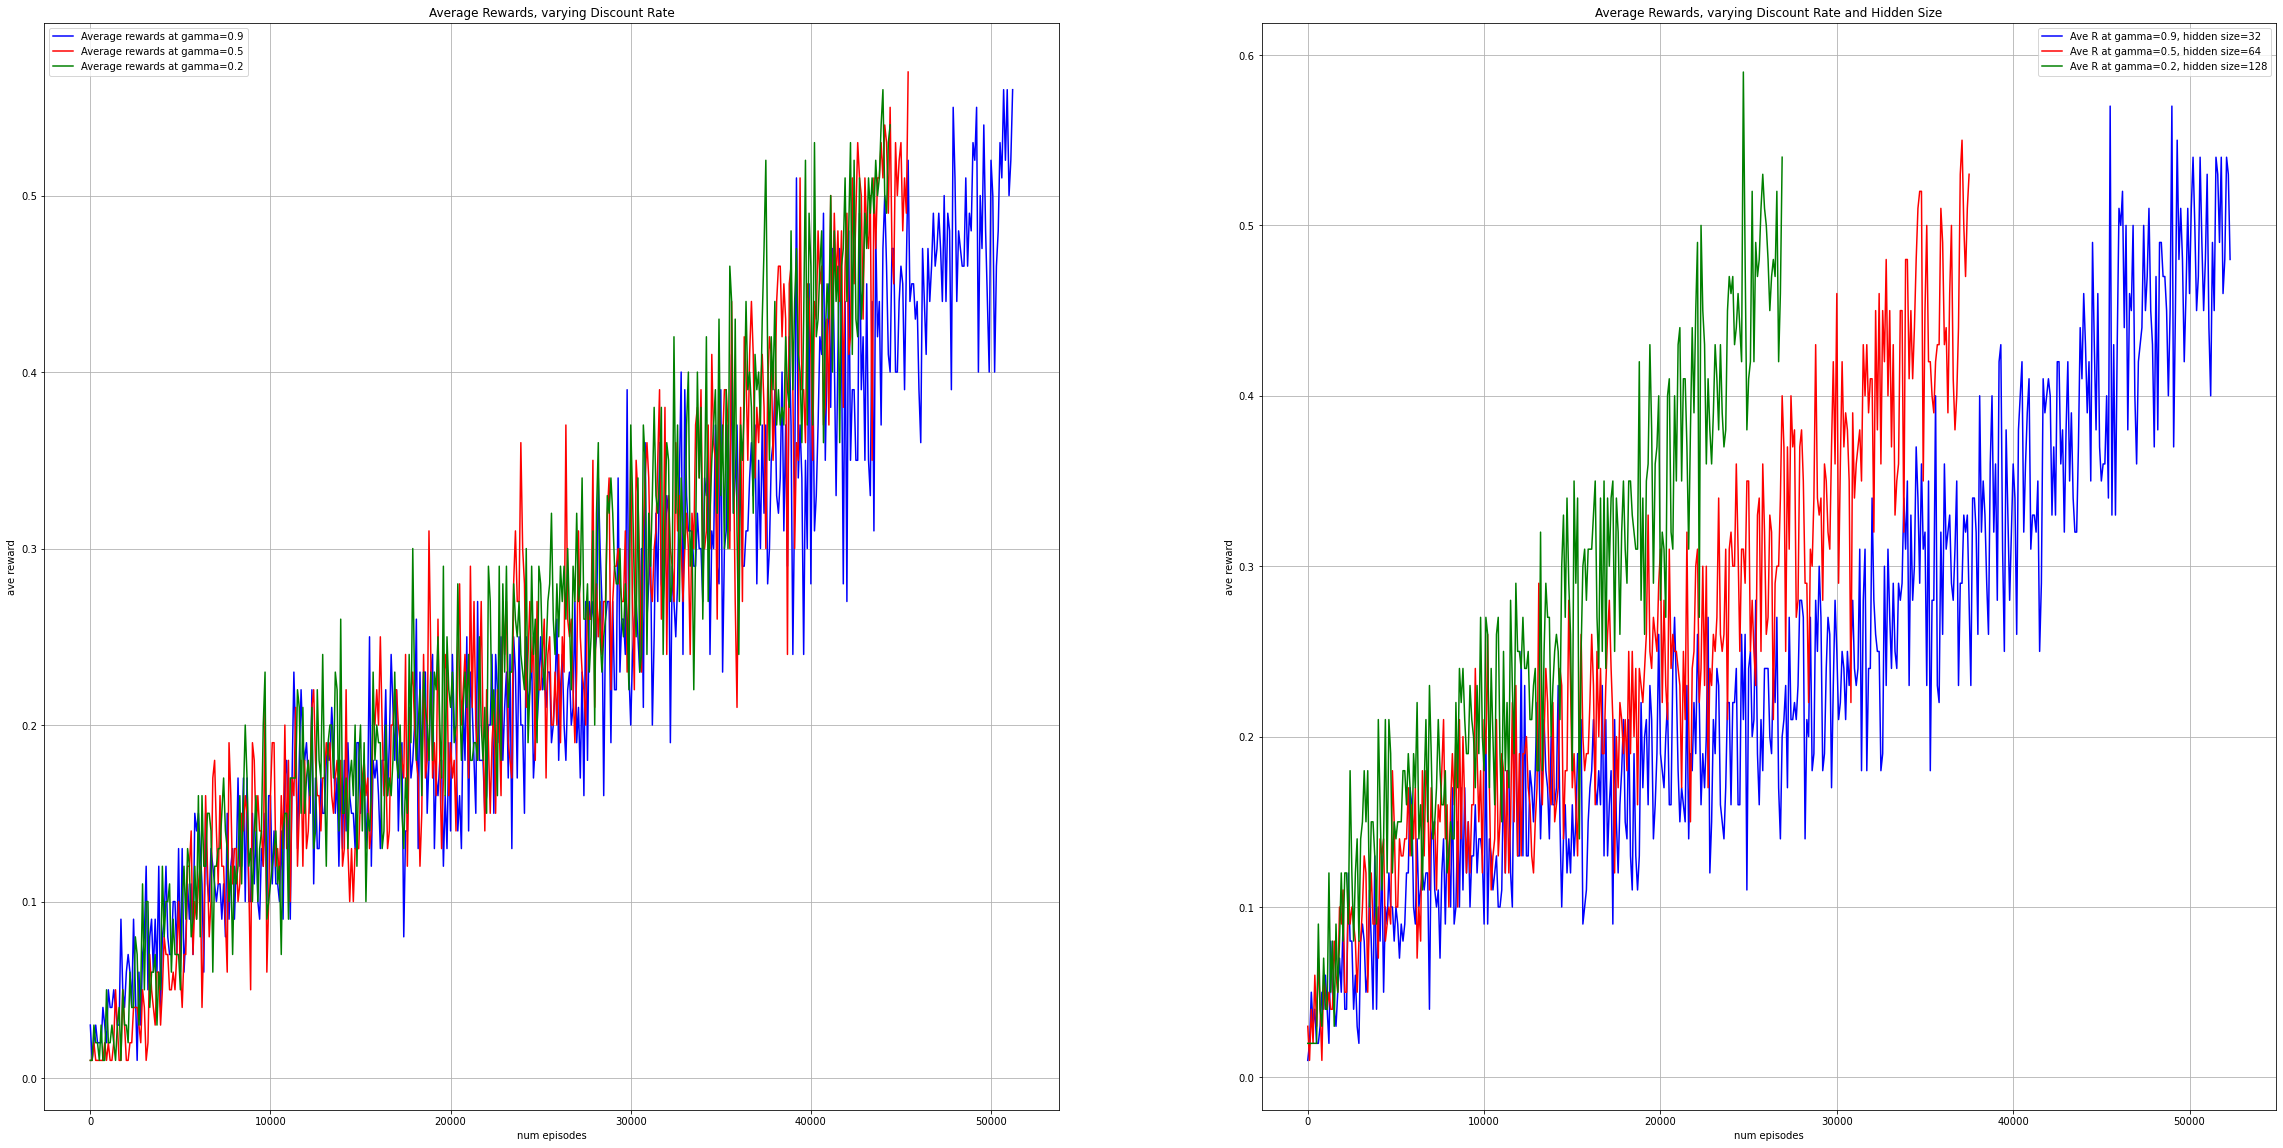

In [129]:

def main():
    """
    We generate 6 plots of cross entropy experiments. In the first 3, we vary gamma. 
    In the last 3 we vary the size of the single hidden layer.
    Running this takes about 15 minutes in all.
    """
    env = gym.make('FrozenLake-v0', is_slippery=False)
    env = OneHotWrapper(env)

    obs_size = env.observation_space.shape[0]  # 16
    n_actions = env.action_space.n  # 4
    batch_size= 100
    percentile = 70
    reward_goal = 0.70
    plt.rcParams['figure.figsize'] = [40, 20]
    f, (sp1, sp2) = plt.subplots(1,2)

    gamma0 = 0.9
    net0 = Net(obs_size=obs_size, hidden_size=32, n_actions=n_actions)
    mean_rewards0 = cross_entropy(net0, env, gamma0, batch_size, percentile, reward_goal)
    episodes = [e for e in range(0, len(mean_rewards0)*batch_size) if e % batch_size== 0]
    sp1.plot(episodes,mean_rewards0, 'b', label='Average rewards at gamma={}'.format(gamma0))

    gamma1 = 0.5
    net1 = Net(obs_size=obs_size, hidden_size=64, n_actions=n_actions)
    mean_rewards1 = cross_entropy(net1, env, gamma1, batch_size, percentile, reward_goal)
    episodes = [e for e in range(0, len(mean_rewards1)*batch_size) if e % batch_size== 0]
    sp1.plot(episodes, mean_rewards1, 'r', label='Average rewards at gamma={}'.format(gamma1))

    gamma2 = 0.2
    net2 = Net(obs_size=obs_size, hidden_size=64, n_actions=n_actions)
    mean_rewards2 = cross_entropy(net2,env, gamma2, batch_size, percentile, reward_goal)
    episodes = [e for e in range(0, len(mean_rewards2)*batch_size) if e % batch_size== 0]
    sp1.plot(episodes, mean_rewards2, 'g', label='Average rewards at gamma={}'.format(gamma2))

    sp1.legend()
    sp1.set(xlabel='num episodes', ylabel='ave reward',
            title='Average Rewards, varying Discount Rate')
    sp1.grid()

    net3 = Net(obs_size=obs_size, hidden_size=32, n_actions=n_actions)
    gamma3 = 0.9
    mean_rewards3 = cross_entropy(net3, env, gamma3, batch_size, percentile, reward_goal)
    episodes = [e for e in range(0, len(mean_rewards3) * batch_size) if e % batch_size == 0]
    sp2.plot(episodes, mean_rewards3, 'b', label='Ave R at gamma={}, hidden size=32'.format(gamma0))

    net4 = Net(obs_size=obs_size, hidden_size=64, n_actions=n_actions)
    gamma1 = 0.5
    mean_rewards4 = cross_entropy(net4, env, gamma1, batch_size, percentile, reward_goal)
    episodes = [e for e in range(0, len(mean_rewards4) * batch_size) if e % batch_size == 0]
    sp2.plot(episodes, mean_rewards4, 'r', label='Ave R at gamma={}, hidden size=64'.format(gamma1))

    net5 = Net(obs_size=obs_size, hidden_size=128, n_actions=n_actions)
    gamma5 = 0.2
    mean_rewards5 = cross_entropy(net5, env, gamma5, batch_size, percentile, reward_goal)
    episodes = [e for e in range(0, len(mean_rewards5) * batch_size) if e % batch_size == 0]
    sp2.plot(episodes, mean_rewards5, 'g', label='Ave R at gamma={}, hidden size=128'.format(gamma2))

    sp2.legend()
    sp2.set(xlabel='num episodes', ylabel='ave reward',
           title='Average Rewards, varying Discount Rate and Hidden Size')
    sp2.grid()
    plt.show()


if __name__ == "__main__":
    main()

### Analysis
The plot on the left shows different runs with different discount rates. The green and red graphs show discount rates for 0.2 and 0.5 respectively. Too high of a discount rate (e.g. 0.9 for blue graph) and learning slows.
The plot on the right shos different runs with different discount rates and different hidden layer sizes. This seems to suggest that larger hidden layer sizes improves learning.